In [ ]:
!pip install yahoo_fin

In [ ]:
!pip install statsmodels --upgrade

# COMPARISON OF BIOPHARMACEUTICAL COMPANY STOCKS

https://www.investopedia.com/ask/answers/052015/who-are-pfizers-pfe-main-competitors.asp

In [ ]:
# Import the plotting library
%matplotlib inline
import matplotlib.pyplot as plt

# Import the Yahoo Finance module Yahoo_fin (i.e. an alternative to "yfinance")
#Yahoo_fin tutorial available here: http://theautomatic.net/yahoo_fin-documentation/#get_financials
from yahoo_fin.stock_info import *

import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt



In [ ]:
#function for total revenue, cost of revenue, free cash flow
def processdf(ticker):
  field=["totalRevenue", "costOfRevenue","totalCashFromOperatingActivities", "capitalExpenditures"]
  #revenue and cost of revenue
  inc=get_income_statement(ticker, yearly=False).loc[field[:2]]
  #free cash flow from total cash and capital expenditures
  cfl=get_cash_flow(ticker, yearly=False).loc[field[2:]]

  #rearrange dataframe
  df=inc.append(cfl)
  df =df.transpose()
  df["Free cash flow"] = df["totalCashFromOperatingActivities"] + df["capitalExpenditures"]
  df = df[["totalRevenue","costOfRevenue" ,"Free cash flow"]]
  df.rename(columns={'totalRevenue': 'Total Rev_'+ ticker.lower(), 'costOfRevenue': 'Cost Of Rev_'+ ticker.lower(), 'Free cash flow' : 'Free cash fl_' + ticker.lower()}, inplace=True)
  return df

#function to calculate Graham number
def GrahamNum(ticker):
  EPS=get_quote_data(ticker).get('epsTrailingTwelveMonths')
  BVPS=get_quote_data(ticker).get('bookValue')
  constInt = 22.5
  highestPrice = np.sqrt(constInt*EPS*BVPS)
  return highestPrice  

In [ ]:
#lly
df_lly=processdf('LLY')
df_lly=df_lly.reset_index()
df_lly

Breakdown,endDate,Total Rev_lly,Cost Of Rev_lly,Free cash fl_lly
0,2021-06-30,6740100000,1530200000,1.3942e+09
1,2021-03-31,6805600000,1878600000,1.3971e+09
2,2020-12-31,7440000000,1719800000,1.3605e+09
3,2020-09-30,5740600000,1326400000,1.4135e+09


In [ ]:
#pfe
df_pfe=processdf('PFE')
df_pfe=df_pfe.reset_index()
df_pfe.drop(df_pfe.columns[[0]], axis=1, inplace=True)
df_pfe

Breakdown,Total Rev_pfe,Cost Of Rev_pfe,Free cash fl_pfe
0,18977000000,6992000000,1.0759e+10
1,14582000000,4172000000,3.984e+09
2,11684000000,2887000000,3.984e+09
3,12131000000,2497000000,1.565e+09


In [ ]:
#mrk
df_mrk=processdf('MRK')
df_mrk=df_mrk.reset_index()
df_mrk.drop(df_mrk.columns[[0]],axis=1,inplace=True)
df_mrk

Breakdown,Total Rev_mrk,Cost Of Rev_mrk,Free cash fl_mrk
0,11402000000,3029000000,5.05e+08
1,10627000000,2984000000,6.57e+08
2,12515000000,3601000000,2.492e+09
3,12551000000,3443000000,6.57e+08


In [ ]:
#create a unique dataframe for the three stocks
from functools import reduce
df_list=[df_lly,df_mrk,df_pfe]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), df_list)
df_final=df_final.set_index('endDate')
df_final

Breakdown,Total Rev_lly,Cost Of Rev_lly,Free cash fl_lly,Total Rev_mrk,Cost Of Rev_mrk,Free cash fl_mrk,Total Rev_pfe,Cost Of Rev_pfe,Free cash fl_pfe
endDate,,,,,,,,,
2021-06-30,6740100000,1530200000,1.3942e+09,11402000000,3029000000,5.05e+08,18977000000,6992000000,1.0759e+10
2021-03-31,6805600000,1878600000,1.3971e+09,10627000000,2984000000,6.57e+08,14582000000,4172000000,3.984e+09
2020-12-31,7440000000,1719800000,1.3605e+09,12515000000,3601000000,2.492e+09,11684000000,2887000000,3.984e+09
2020-09-30,5740600000,1326400000,1.4135e+09,12551000000,3443000000,6.57e+08,12131000000,2497000000,1.565e+09


[Text(0.5, 0, ''), Text(0.5, 0, ''), Text(0.5, 0, '')]

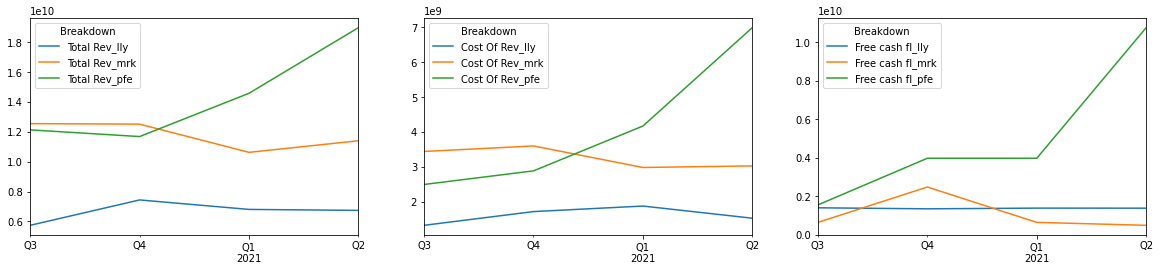

In [ ]:
#plot total revenue, cost of revenue, free cash flow
fig, axarr = plt.subplots(1,3,figsize=(20,4))
[p.set_xlabel("") for p in axarr.flatten()]
df_final.iloc[:,[0,3,6]].plot(ax=axarr[0])
df_final.iloc[:,[1,4,7]].plot(ax=axarr[1])
df_final.iloc[:,[2,5,8]].plot(ax=axarr[2])
[p.set_xlabel("") for p in axarr.flatten()]

In [ ]:
ticker_list = ['lly', 'mrk', 'pfe']
gra_num=[]
mk_price=[]
eps_trail=[]
bk_value=[]
price_book=[]
for ticker in ticker_list:
  gra_num.append(GrahamNum(ticker))
  mk_price.append(get_quote_data(ticker).get('regularMarketPrice'))
  eps_trail.append(get_quote_data(ticker).get('epsTrailingTwelveMonths'))
  bk_value.append(get_quote_data(ticker).get('bookValue'))
  price_book.append(get_quote_data(ticker).get('priceToBook'))

In [ ]:
#summary table for Grahan munmer, price, eps, book value and price to book value
data_stock = {'Graham Number': gra_num,'regularMarketPrice':  mk_price, 'epsTrailingTwelveMonths' : eps_trail,
        'bookValue': bk_value, 'priceToBook': price_book }
index = ['lly', 'mrk', 'pfe']
      
summary = pd.DataFrame (data_stock, index=index)
summary

,Graham Number,regularMarketPrice,epsTrailingTwelveMonths,bookValue,priceToBook
lly,32.614171,231.64,6.650,7.109,32.584050
mrk,25.485181,71.93,2.196,13.145,5.472043
pfe,25.675172,44.20,2.342,12.510,3.533174


#PREPARE EPS DATA FOR PFIZER

In [ ]:
ticker_eps=pd.DataFrame(get_earnings_history('pfe'))
ticker_eps.sort_values(by='startdatetime', ascending=True, inplace=True)
ticker_eps=ticker_eps.reset_index()
ticker_eps.drop(ticker_eps.columns[[0]],axis=1,inplace=True)
ticker_eps.iloc[90:]


,ticker,companyshortname,startdatetime,startdatetimetype,epsestimate,epsactual,epssurprisepct,timeZoneShortName,gmtOffsetMilliSeconds,quoteType
90,PFE,Pfizer Inc.,2020-04-28T00:00:00.000Z,TNS,0.73,0.80,8.99,EDT,0,EQUITY
91,PFE,Pfizer Inc.,2020-07-28T00:00:00.000Z,TNS,0.66,0.78,17.65,EDT,0,EQUITY
92,PFE,Pfizer Inc.,2020-10-27T00:00:00.000Z,TNS,0.71,0.72,0.84,EDT,0,EQUITY
93,PFE,Pfizer Inc.,2021-02-02T00:00:00.000Z,TNS,0.48,0.42,-13.04,EDT,0,EQUITY
94,PFE,Pfizer Inc.,2021-05-04T00:00:00.000Z,TNS,0.77,0.93,20.31,EDT,0,EQUITY
95,PFE,Pfizer Inc.,2021-07-28T00:00:00.000Z,TNS,0.97,1.07,10.20,EDT,0,EQUITY
96,PFE,Pfizer Inc,2021-10-25T12:30:00.000Z,BMO,1.08,NaN,NaN,EDT,-14400000,EQUITY
97,PFE,Pfizer Inc,2022-01-31T13:30:00.000Z,BMO,NaN,NaN,NaN,EDT,-14400000,EQUITY
98,PFE,Pfizer Inc,2022-05-02T12:30:00.000Z,BMO,NaN,NaN,NaN,EDT,-14400000,EQUITY
99,PFE,Pfizer Inc,2022-07-26T12:30:00.000Z,BMO,NaN,NaN,NaN,EDT,-14400000,EQUITY


In [ ]:
#create a date column
ticker_eps['Date']= [ticker_eps['startdatetime'][i][:10] for i in range(len(ticker_eps['startdatetime']))]
ticker_eps = ticker_eps.iloc[:96]
ticker_eps.head()

,ticker,companyshortname,startdatetime,startdatetimetype,epsestimate,epsactual,epssurprisepct,timeZoneShortName,gmtOffsetMilliSeconds,quoteType,Date
0,PFE,Pfizer Inc.,1997-10-14T00:00:00.000Z,TNS,0.15,0.15,3.95,EDT,0,EQUITY,1997-10-14
1,PFE,Pfizer Inc.,1998-01-20T00:00:00.000Z,TNS,0.14,0.14,-0.08,EDT,0,EQUITY,1998-01-20
2,PFE,Pfizer Inc.,1998-04-14T00:00:00.000Z,TNS,0.18,0.18,-0.67,EDT,0,EQUITY,1998-04-14
3,PFE,Pfizer Inc.,1998-07-09T00:00:00.000Z,TNS,0.15,0.17,13.64,EDT,0,EQUITY,1998-07-09
4,PFE,Pfizer Inc.,1998-10-13T00:00:00.000Z,TNS,0.19,0.17,-10.04,EDT,0,EQUITY,1998-10-13


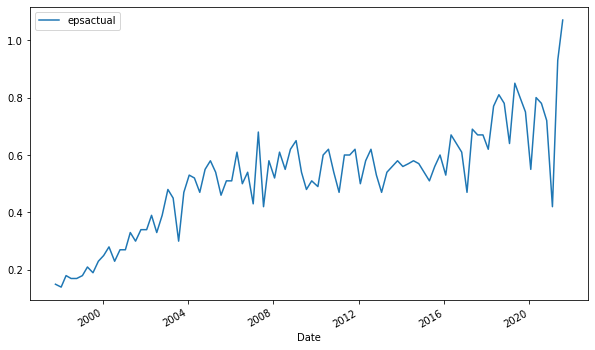

In [ ]:
#new dataframe with only EPS values and Date
eps_series =ticker_eps.loc[:,['Date','epsactual']]
eps_series['Date']=pd.to_datetime(eps_series['Date'])
eps_series.set_index('Date', inplace=True)
eps_series.plot(figsize=(10,6))

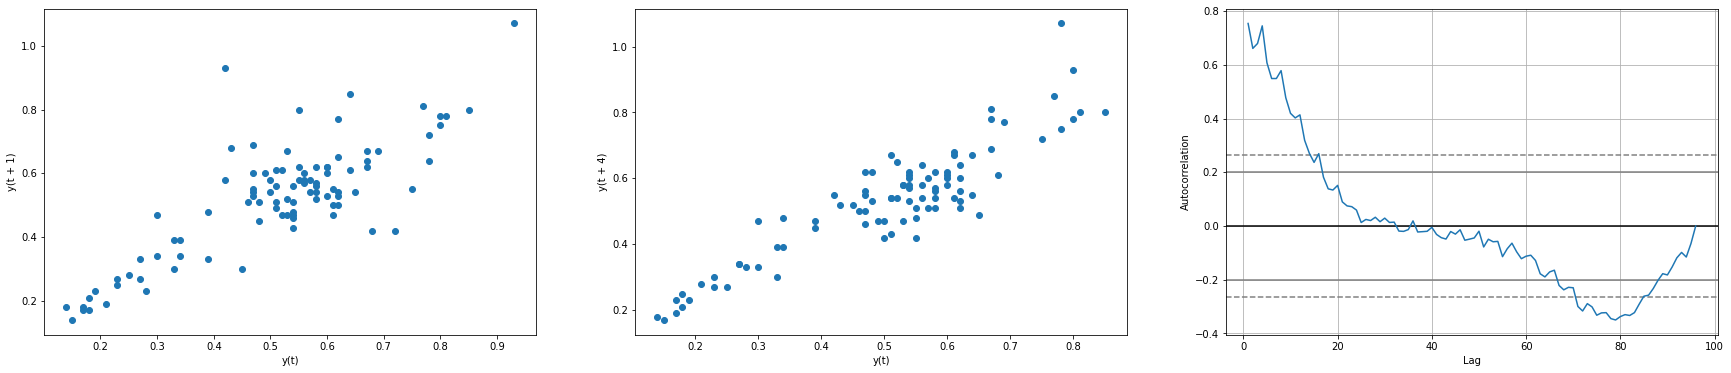

In [ ]:
#lag plot for lag 1 and lag 4 and autocorrelation
fig, axarr = plt.subplots(1,3,figsize=(30,6))
lag_plot(eps_series['epsactual'], ax=axarr[0])
lag_plot(eps_series['epsactual'], lag=4,ax=axarr[1])
autocorrelation_plot(eps_series['epsactual'],ax=axarr[2])

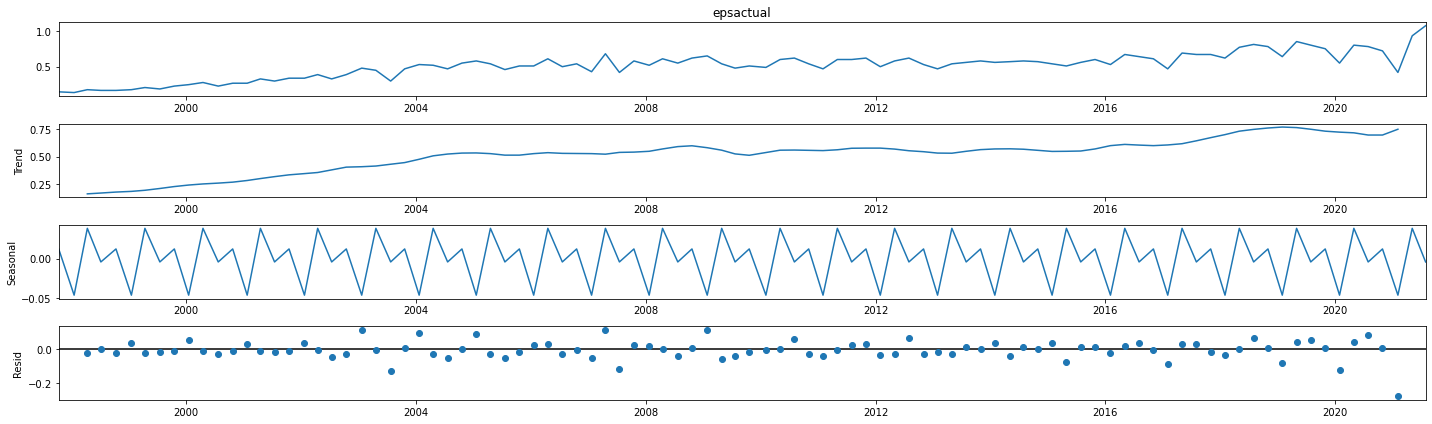

In [ ]:
#decompose components
decomposed = seasonal_decompose(eps_series['epsactual'], model='additive',period=4)
plt.rcParams["figure.figsize"] = (20,6)
x=decomposed.plot()

#FORECASTING

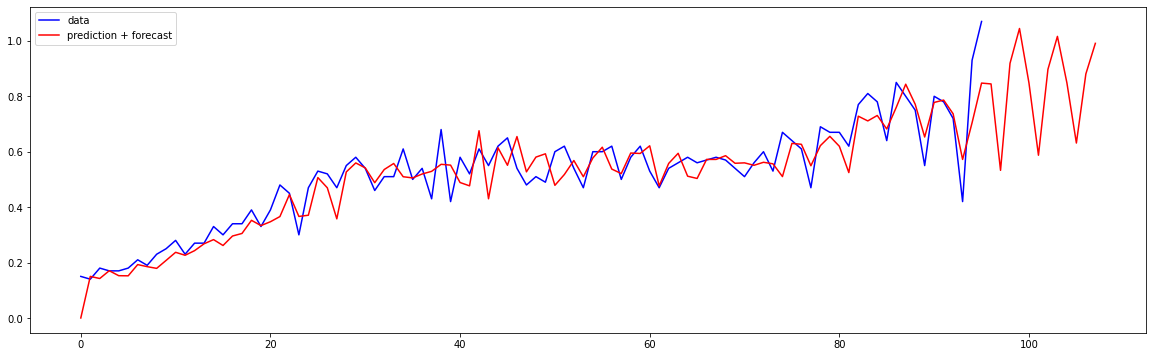

0.07088662436352289


In [ ]:
# Load the statsmodels api
import statsmodels.api as sm
order = (4, 1, 0)#p,d, q--> d=integration to have the series stationary
seasonal_order = (0, 0, 0, 0) #P,D,Q,M
trend ="n"
X = eps_series['epsactual'].values
model = sm.tsa.statespace.SARIMAX(X, order=order, seasonal_order=seasonal_order, trend=trend)
# fit model
model_fit = model.fit()
predictions = model_fit.predict(start=0, end=len(X)-1+12, dynamic=False)

#plot
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(X, color='blue', label='data')
#pyplot.plot(test, color='blue')
plt.plot(predictions, color='red', label= 'prediction + forecast')
plt.legend(loc="upper left")
plt.show()
rmse = sqrt(mean_squared_error(X, predictions[:96]))
print(rmse)

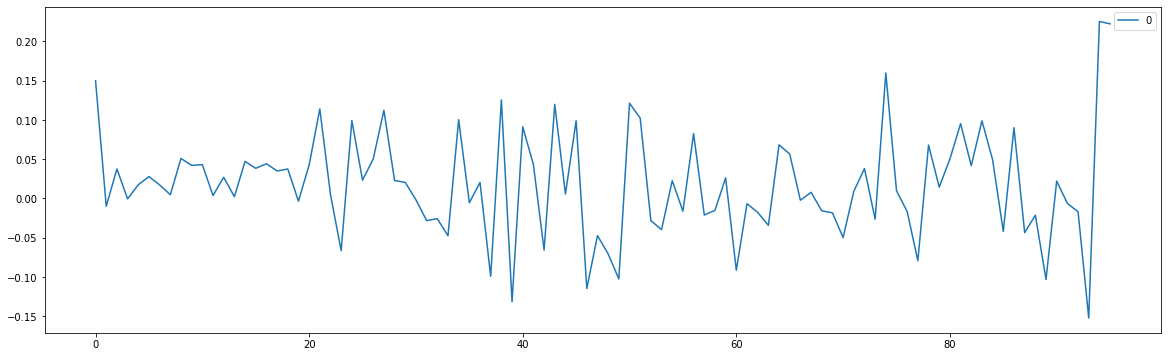

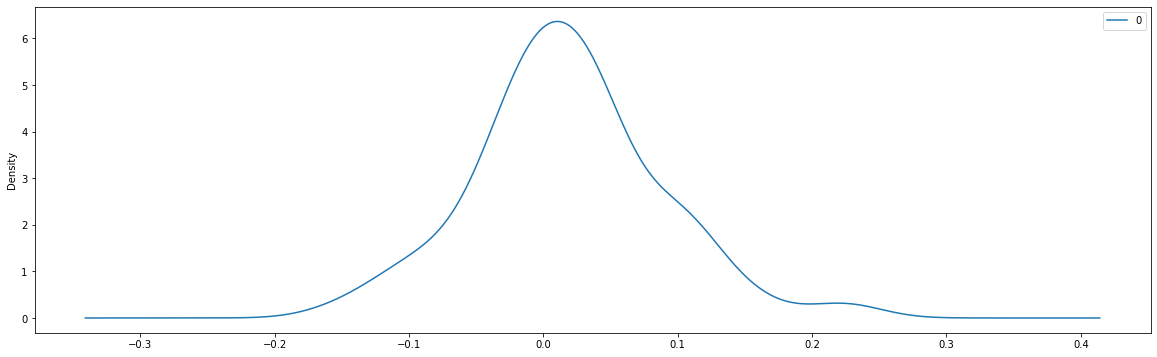

               0
count  96.000000
mean    0.017932
std     0.068941
min    -0.152128
25%    -0.018959
50%     0.015911
75%     0.049503
max     0.225385


In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
#dataframe with results
data = {'EPS Forecasting':  list(predictions[-12:])}
index = ['2021-10-25', '2022-01-31','2022-05-02','2022-07-26','2022-10-25', '2023-01-31','2023-05-02','2023-07-26',
         '2023-10-25', '2024-01-31','2024-05-02','2024-07-26',]
      
df = pd.DataFrame (data, columns = ['EPS Forecasting'], index=index)
df.transpose()

,2021-10-25,2022-01-31,2022-05-02,2022-07-26,2022-10-25,2023-01-31,2023-05-02,2023-07-26,2023-10-25,2024-01-31,2024-05-02,2024-07-26
EPS Forecasting,0.84456,0.532783,0.918975,1.044639,0.847722,0.587293,0.897335,1.016173,0.84844,0.63128,0.88079,0.99104
